In [1]:
import PIL
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

In [2]:
img = PIL.Image

In [3]:
not_path = './not_dog_images/'
not_resized_path = './not_dog_images_resized/'


In [3]:
dog_path = "./redownload_dog_images/"
dog_resized_path = './redownload_images_resized/'

In [117]:
if not os.path.exists(dog_resized_path):
    os.makedirs(dog_resized_path)

In [11]:
not_dog_list = os.listdir('./not_dog_images')

In [122]:
for image in dog_path:
    read = img.open(dog_path + image)
    resize = read.resize((299, 299), img.NEAREST)
    resize.save(f'{dog_resized_path}{image}') 

PermissionError: [Errno 13] Permission denied: './redownload_dog_images/.'

In [4]:
dog_list = os.listdir(dog_path)

In [124]:
for image in dog_list:
    read = img.open(dog_path + image)
    resize = read.resize((299, 299), img.NEAREST)
    resize.save(f'{dog_resized_path}{image}')

In [4]:
true = []

for image in os.listdir(dog_resized_path):
    read = plt.imread(f'{dog_resized_path}{image}')
    true.append(read)

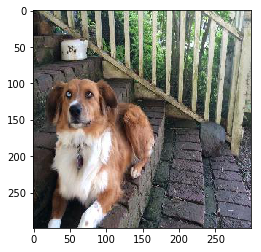

In [5]:
plt.imshow(true[0])

In [6]:
true = np.array(true)/255

In [34]:
false = []

for image in os.listdir(not_resized_path):
    read = plt.imread(f'{not_resized_path}{image}')
    false.append(read)

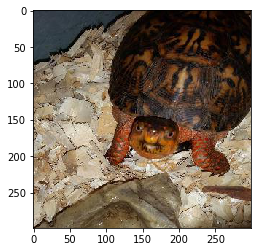

In [35]:
plt.imshow(false[0])

In [36]:
false = np.array(false)/255

In [37]:
X = np.concatenate([true, false])

In [7]:
X_ = true

In [38]:
true_labels = [1 for i in range(len(true))]
false_labels = [0 for i in range(len(false))]

In [39]:
y = np.concatenate([true_labels, false_labels])

In [40]:
perm = np.random.permutation(len(X))

In [42]:
X_ = X[perm]
y_ = y[perm]

In [42]:
true_indexes = np.array(os.listdir(dog_resized_path))

In [54]:
false_indexes = np.array(os.listdir(not_resized_path))

In [58]:
all_index = np.concatenate([true_indexes, false_indexes])[perm]

In [16]:
x_train = X[:550].astype(np.float32)
x_test = X[550:].astype(np.float32)

y_train = y[:550].astype(np.int32)
y_test = y[550:].astype(np.int32)

In [17]:
x_train.shape, x_test.shape

((550, 299, 299, 3), (156, 299, 299, 3))

In [18]:
x_train.shape

(550, 299, 299, 3)

In [19]:
def shuffle_batch(x, y, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x)//batch_size
    for batch in np.array_split(rnd_idx, n_batches):
        x_batch, y_batch = x[batch], y[batch]
        yield x_batch, y_batch

In [20]:
n_outputs = 2

In [606]:
tf.reset_default_graph()

In [607]:
with tf.name_scope('placeholders'):
    X = tf.placeholder(tf.float32, shape = [None, 299, 299, 3], name = 'X')
    X_reshaped = tf.reshape(X, [-1, 299, 299, 3])
    y = tf.placeholder(tf.int32, shape = [None,], name = 'y')
    
    bn1 = tf.placeholder_with_default(True, shape = (), name = 'bn1')
    bn2 = tf.placeholder_with_default(True, shape = (), name = 'bn2')
    bn3 = tf.placeholder_with_default(True, shape = (), name = 'bn3')
    
    drop1 = tf.placeholder_with_default(True, shape = (), name = 'drop1')
    drop2 = tf.placeholder_with_default(True, shape = (), name = 'drop2')
    drop3 = tf.placeholder_with_default(True, shape = (), name = 'drop3')

In [608]:
with tf.name_scope("conv"):
    conv1 = tf.layers.conv2d(X_reshaped, 128, [2, 2], strides = [2,2], padding = 'SAME', name = 'conv1')
    pool1 = tf.layers.max_pooling2d(conv1, [4, 4], strides = [4,4],  name = 'pool1')
    batch_norm1 = tf.layers.batch_normalization(pool1, momentum = 0.9, training = bn1)
    dropout1 = tf.layers.dropout(batch_norm1, 0.5, training = drop1)
    
    conv2 = tf.layers.conv2d(dropout1, 256, [2, 2], strides = [2,2],padding = 'SAME', name = 'conv2')
    pool2 = tf.layers.max_pooling2d(conv2, [4, 4], strides = [4,4], name = 'pool2')
    batch_norm2 = tf.layers.batch_normalization(pool2, momentum = 0.9, training = bn2)
    dropout2 = tf.layers.dropout(batch_norm2, 0.5, training = drop2)
    
    conv3 = tf.layers.conv2d(dropout2, 512, [2, 2], strides = [1,1],padding = 'SAME', name = 'conv3')
    pool3 = tf.layers.max_pooling2d(conv3, [4, 4], strides = [4,4], name = 'pool3')
    batch_norm3 = tf.layers.batch_normalization(pool3, momentum = 0.9, training = bn3)
    dropout3 = tf.layers.dropout(batch_norm3, 0.5, training = drop3)
    
    flatten = tf.reshape(dropout3, [-1, 1*1*512], name = 'flatten')
    
    #fc1 = tf.layers.dense(flatten, 1024, activation = tf.nn.selu, name = 'fc1')
    fc2 = tf.layers.dense(flatten, 64, activation = tf.nn.selu, name = 'fc2')
    
    logits = tf.layers.dense(fc2, n_outputs,  name = 'logits')
    

In [609]:
dropout3.shape

TensorShape([Dimension(None), Dimension(1), Dimension(1), Dimension(512)])

In [610]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = y)
    loss = tf.reduce_mean(xentropy)

In [611]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

In [612]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [613]:
init = tf.global_variables_initializer()
batch_size = 16
n_epochs = 100

In [614]:
saver = tf.train.Saver()

In [615]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    preds = []
    score_keep = []
    score = 0
    for epoch in range(n_epochs):
        for x_batch, y_batch in shuffle_batch(x_train, y_train, batch_size):
            sess.run([update_ops,training_op], feed_dict = {X: x_batch, y: y_batch})
        if epoch % 1 == 0:
            batch_acc = accuracy.eval(feed_dict = {X: x_batch, y: y_batch})
            val_acc = accuracy.eval(feed_dict = {bn1: False, bn2: False, bn3: False,
                                                 drop1: False, drop2: False, drop3: False,
                                                 X: x_test, y: y_test})
            print("Epoch:", epoch, "Batch Accuracy = ", batch_acc, "Validation Accuarcy = ", val_acc)
            if val_acc > score:
                preds = []
                score = val_acc
                score_keep = []
                saver.save(sess, './binary.ckpt')
                predictions = sess.run(logits, feed_dict = {bn1: False, bn2: False, bn3: False,
                                                            drop1: False, drop2: False, drop3: False,
                                                            X: x_test})
                preds.append(predictions)
                    
                
                
                                          

Epoch: 0 Batch Accuracy =  0.75 Validation Accuarcy =  0.44230768
Epoch: 1 Batch Accuracy =  0.625 Validation Accuarcy =  0.5448718
Epoch: 2 Batch Accuracy =  0.6875 Validation Accuarcy =  0.51282054
Epoch: 3 Batch Accuracy =  0.5625 Validation Accuarcy =  0.43589744
Epoch: 4 Batch Accuracy =  0.875 Validation Accuarcy =  0.53846157
Epoch: 5 Batch Accuracy =  0.6875 Validation Accuarcy =  0.53846157
Epoch: 6 Batch Accuracy =  0.75 Validation Accuarcy =  0.5448718
Epoch: 7 Batch Accuracy =  0.375 Validation Accuarcy =  0.525641
Epoch: 8 Batch Accuracy =  0.5625 Validation Accuarcy =  0.53205127
Epoch: 9 Batch Accuracy =  0.6875 Validation Accuarcy =  0.48076922
Epoch: 10 Batch Accuracy =  0.6875 Validation Accuarcy =  0.53846157
Epoch: 11 Batch Accuracy =  0.6875 Validation Accuarcy =  0.5769231
Epoch: 12 Batch Accuracy =  0.5625 Validation Accuarcy =  0.55128205
Epoch: 13 Batch Accuracy =  0.6875 Validation Accuarcy =  0.5897436
Epoch: 14 Batch Accuracy =  0.625 Validation Accuarcy =  

In [616]:
preds = np.array(preds)

In [617]:
predictions = np.argmax(preds, axis = 2)

In [618]:
len(preds[0])

156

In [619]:
y_test

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1])

In [620]:
predictions

array([[0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0]], dtype=int64)

In [621]:
from sklearn.metrics import accuracy_score

In [623]:
accuracy_score(predictions.ravel(), y_test)

0.6410256410256411

In [8]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
#INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")
INCEPTION_V3_CHECKPOINT_PATH = 'C:\\Users\stephen\datascience\datasets\inception\inception_v3.ckpt'

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [9]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("C:/Users/stephen/datascience/oreilly/handson-ml-master/datasets/inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [10]:
class_names = ["background"] + load_class_names()

In [11]:
from tensorflow.contrib.slim.nets import inception

In [12]:
import tensorflow.contrib.slim as slim
tf.reset_default_graph()

In [13]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

In [14]:
predictions = end_points["Predictions"]
saver = tf.train.Saver()

In [15]:
prelogits = tf.squeeze(end_points['PreLogits'], axis = [1,2])
prelogits.shape

TensorShape([Dimension(None), Dimension(2048)])

In [16]:
n_outputs = 2

with tf.name_scope('new_output_layer'):
    binary_logits = tf.layers.dense(prelogits, n_outputs, name = 'binary_logits')
    y_proba = tf.nn.softmax(binary_logits, name = 'y_proba')

In [17]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=binary_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    binary_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="binary_logits")
    training_op = optimizer.minimize(loss, var_list=binary_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(binary_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 

In [653]:
n_epochs = 2
batch_size = 32
n_iterations_per_epoch = len(x_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess,"./binary_inception.ckpt" )
    score = 0
    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            for x_batch, y_batch in shuffle_batch(x_train, y_train, batch_size):
                sess.run(training_op, feed_dict={X: x_batch, y: y_batch, training: True})

                acc_train = accuracy.eval(feed_dict={X: x_batch, y: y_batch})
                val_acc = accuracy.eval(feed_dict = {training: False, X: x_test, y : y_test})
                test_pred = sess.run(binary_logits, feed_dict = {X: x_test})
                print("  Train accuracy:", acc_train, "val acc = ", val_acc)
                if val_acc > score:
                    score = val_acc
                    preds = []
                    preds.append(test_pred)
                    save_path = saver.save(sess, "./binary_inception.ckpt")

INFO:tensorflow:Restoring parameters from ./binary_inception.ckpt
Epoch 0.  Train accuracy: 0.4848485 val acc =  0.44230768
  Train accuracy: 0.6363636 val acc =  0.6025641
  Train accuracy: 0.6363636 val acc =  0.5448718
  Train accuracy: 0.54545456 val acc =  0.5448718
  Train accuracy: 0.54545456 val acc =  0.5833333
  Train accuracy: 0.6666667 val acc =  0.60897434
  Train accuracy: 0.5625 val acc =  0.57051283
  Train accuracy: 0.5 val acc =  0.5448718
  Train accuracy: 0.5625 val acc =  0.5833333
  Train accuracy: 0.65625 val acc =  0.64102566
  Train accuracy: 0.5625 val acc =  0.6730769
  Train accuracy: 0.53125 val acc =  0.65384614
  Train accuracy: 0.625 val acc =  0.5897436
  Train accuracy: 0.5625 val acc =  0.5833333
  Train accuracy: 0.59375 val acc =  0.5897436
  Train accuracy: 0.71875 val acc =  0.6474359
  Train accuracy: 0.46875 val acc =  0.71794873
.  Train accuracy: 0.6969697 val acc =  0.7307692
  Train accuracy: 0.72727275 val acc =  0.71794873
  Train accuracy

  Train accuracy: 0.8484849 val acc =  0.82051283
  Train accuracy: 0.8484849 val acc =  0.8397436
  Train accuracy: 0.93939394 val acc =  0.8076923
  Train accuracy: 0.8787879 val acc =  0.7948718
  Train accuracy: 0.8181818 val acc =  0.7948718
  Train accuracy: 0.875 val acc =  0.7948718
  Train accuracy: 0.9375 val acc =  0.80128205
  Train accuracy: 0.78125 val acc =  0.8397436
  Train accuracy: 0.875 val acc =  0.8333333
  Train accuracy: 0.78125 val acc =  0.8141026
  Train accuracy: 0.90625 val acc =  0.7948718
  Train accuracy: 0.90625 val acc =  0.76282054
  Train accuracy: 0.75 val acc =  0.74358976
  Train accuracy: 0.84375 val acc =  0.74358976
  Train accuracy: 0.84375 val acc =  0.73717946
  Train accuracy: 0.875 val acc =  0.73717946
.  Train accuracy: 0.75757575 val acc =  0.76282054
  Train accuracy: 0.8787879 val acc =  0.78846157
  Train accuracy: 0.8484849 val acc =  0.7948718
  Train accuracy: 0.8484849 val acc =  0.82051283
  Train accuracy: 0.8484849 val acc =  

  Train accuracy: 0.90909094 val acc =  0.8141026
  Train accuracy: 0.93939394 val acc =  0.8076923
  Train accuracy: 0.8181818 val acc =  0.78846157
  Train accuracy: 0.75 val acc =  0.78846157
  Train accuracy: 0.875 val acc =  0.7692308
  Train accuracy: 0.84375 val acc =  0.7692308
  Train accuracy: 0.9375 val acc =  0.7692308
  Train accuracy: 0.78125 val acc =  0.775641
  Train accuracy: 0.90625 val acc =  0.78846157
  Train accuracy: 0.90625 val acc =  0.78846157
  Train accuracy: 0.84375 val acc =  0.80128205
  Train accuracy: 0.84375 val acc =  0.80128205
  Train accuracy: 0.84375 val acc =  0.80128205
  Train accuracy: 0.875 val acc =  0.80128205
.  Train accuracy: 0.90909094 val acc =  0.8076923
  Train accuracy: 0.8787879 val acc =  0.8141026
  Train accuracy: 0.90909094 val acc =  0.8141026
  Train accuracy: 0.8787879 val acc =  0.8141026
  Train accuracy: 0.8181818 val acc =  0.8141026
  Train accuracy: 0.90909094 val acc =  0.7948718
  Train accuracy: 0.875 val acc =  0.

KeyboardInterrupt: 

In [654]:
predictions = np.argmax(preds, axis = 2)

In [655]:
predictions

array([[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1]], dtype=int64)

In [656]:
y_test

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1])

In [657]:
accuracy_score(predictions.ravel(), y_test)

0.8397435897435898

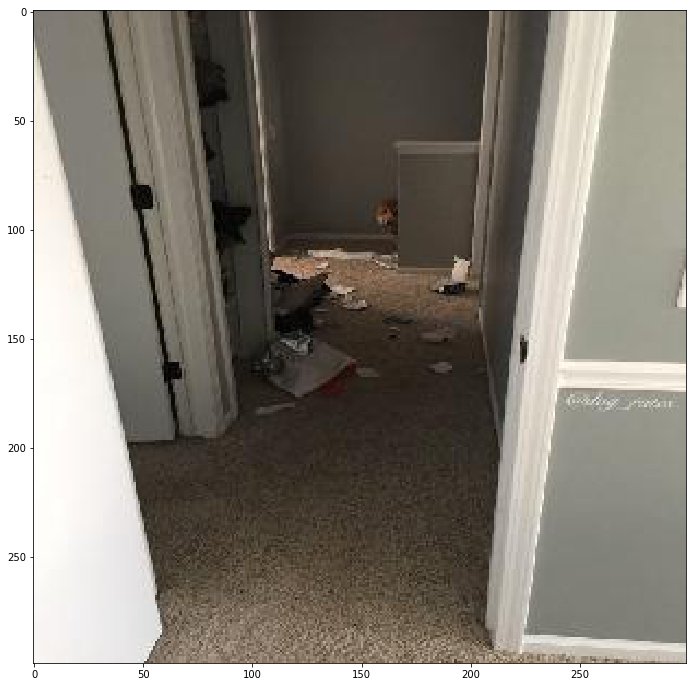

In [662]:
plt.figure(figsize = (12,12))
plt.imshow(x_test[1])

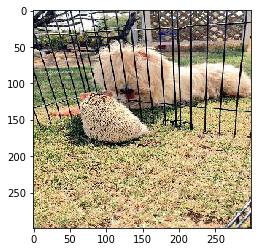

In [664]:
plt.imshow(x_test[10])

In [50]:
def feeder(images):
    
    batch_size = 16
    n_batches = len(images)//batch_size
    
    for image_batch in 

In [52]:
for image in X_[:5]

array([1380, 1562, 1316, ...,   22, 1302, 1254])

In [54]:


predictions = []

with tf.Session() as sess:
    saver.restore(sess, "./binary_inception.ckpt")
    for image in X_:
        preds = sess.run(binary_logits, feed_dict = {training: False, X: image.reshape(-1, 299, 299, 3)})
        predictions.append(preds)

INFO:tensorflow:Restoring parameters from ./binary_inception.ckpt


In [61]:
import pandas as pd

In [62]:
df = pd.read_csv("./final_df.csv")

In [64]:
df['neural_pred'] = preds

ValueError: Length of values does not match length of index

In [82]:
predict_false_idx = list(df.query('p1_dog == False & p2_dog == False & p3_dog == False').index)

In [65]:
preds = np.argmax(predictions, axis = 2).ravel()

In [68]:
X_.shape

(2067, 299, 299, 3)

In [44]:
def clean_jpg(index):
    new = []
    for idx in index:
        cleaned = idx.replace('.jpg', '')
        new.append(cleaned)
    return new

In [46]:
pred_index = clean_jpg(true_indexes)

In [70]:
df = df[:-1]

In [71]:
df['neural_pred'] = preds

c:\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
df.head(100)

tweet_id  favorites  retweets  \
0   666020888022790149       2541       507   
1   666029285002620928        129        47   
2   666033412701032449        125        44   
3   666044226329800704        296       139   
4   666049248165822465        108        41   
5   666050758794694657        132        59   
6   666051853826850816       1209       841   
7   666055525042405380        432       243   
8   666057090499244032        294       141   
9   666058600524156928        111        57   
10  666063827256086533        471       215   
11  666071193221509120        145        59   
12  666073100786774016        318       162   
13  666082916733198337        116        44   
14  666094000022159362        163        72   
15  666099513787052032        153        67   
16  666102155909144576         80        12   
17  666104133288665088      14155      6476   
18  666268910803644416        102        35   
19  666273097616637952        174        76   
20  666287406224695296        146        64   
21  666293911632134144        494       352   
22  666337882303524864        196        90   
23  666345417576210432        290       133   
24  666353288456101888        217        71   
25  666362758909284353        770       564   
26  666373753744588802        186        92   
27  666396247373291520        166        84   
28  666407126856765440        107        40   
29  666411507551481857        441       323   
..                 ...        ...       ...   
70  667192066997374976        390       109   
71  667200525029539841        622       265   
72  667211855547486208        498       245   
73  667369227918143488        370       167   
74  667393430834667520        198        58   
75  667405339315146752        473       221   
76  667435689202614272        308        84   
77  667437278097252352        452       242   
78  667443425659232256        792       591   
79  667453023279554560        318        91   
80  667455448082227200        194        60   
81  667470559035432960        259       100   
82  667491009379606528        538       232   
83  667495797102141441        527       276   
84  667502640335572993        538       223   
85  667509364010450944       6858      2167   
86  667517642048163840        371       196   
87  667524857454854144       1721      1131   
88  667530908589760512        475       245   
89  667534815156183040        830       551   
90  667538891197542400        208        67   
91  667544320556335104        878       533   
92  667546741521195010        338       127   
93  667549055577362432       5870      2330   
94  667550882905632768          0        33   
95  667550904950915073          0        35   
96  667724302356258817        491       326   
97  667728196545200128        380       152   
98  667766675769573376        448       222   
99  667773195014021121        239        58   

                                            jpg_url  img_num  \
0   https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg        1   
1   https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg        1   
2   https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg        1   
3   https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg        1   
4   https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg        1   
5   https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg        1   
6   https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg        1   
7   https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg        1   
8   https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg        1   
9   https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg        1   
10  https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg        1   
11  https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg        1   
12  https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg        1   
13  https://pbs.twimg.com/media/CT5m4VGWEAAtKc8.jpg        1   
14  https://pbs.twimg.com/media/CT5w9gUW4AAsBNN.jpg        1   
15  https://pbs.twimg.com/media/CT51-JJUEAA6hV8.jpg        1   
16  https:/

In [77]:
df.to_csv("./binary.csv", index = False)

In [101]:
0 in pred_index

False

In [104]:
pred_index

['57',
 '181',
 '268',
 '447',
 '347',
 '660',
 '727',
 '9',
 '590',
 '717',
 '2016',
 '832',
 '1242',
 '174',
 '155',
 '777',
 '260',
 '840',
 '562',
 '104',
 '259',
 '227',
 '787',
 '1260',
 '101',
 '407',
 '675',
 '17',
 '695',
 '541',
 '484',
 '559',
 '581',
 '144',
 '82',
 '536',
 '460',
 '202',
 '66',
 '705',
 '19',
 '1284',
 '355',
 '402',
 '1036',
 '54',
 '673',
 '351',
 '648',
 '591',
 '172',
 '117',
 '343',
 '611',
 '463',
 '69',
 '24',
 '12',
 '262',
 '1844',
 '757',
 '307',
 '795',
 '468',
 '32',
 '789',
 '228',
 '441',
 '59',
 '272',
 '299',
 '62',
 '177',
 '629',
 '204',
 '474',
 '389',
 '698',
 '528',
 '1369',
 '682',
 '728',
 '36',
 '1217',
 '517',
 '392',
 '702',
 '752',
 '489',
 '502',
 '582',
 '313',
 '419',
 '354',
 '154',
 '510',
 '711',
 '671',
 '654',
 '326',
 '679',
 '593',
 '345',
 '110',
 '672',
 '445',
 '377',
 '45',
 '247',
 '156',
 '680',
 '190',
 '772',
 '336',
 '94',
 '28',
 '686',
 '783',
 '652',
 '459',
 '249',
 '418',
 '97',
 '1093',
 '214',
 '747',
 '

In [60]:
df.head()

NameError: name 'df' is not defined

In [75]:
preds[100:300]

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1], dtype=int64)